In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings('ignore')
k_fold = 10
seed = 42
np.random.seed(seed)

In [2]:
repeated_stratify_cv = RepeatedStratifiedKFold(n_splits=k_fold, n_repeats=3, random_state=seed)

In [3]:
def describe_dataset(dataset_path: str):
    ''''''

    data = pd.read_csv(dataset_path)
    print(f"Headers: {list(data.columns.values)}")
    print(f'Number of rows: {data.shape[0]} \nNumber of columns: {data.shape[1]}\n')
    print(f"Labels: \n{data['label'].value_counts()}\n")
    print(f"Missing values: {data.isnull().values.any()}\n")
    duplicate = data[data.duplicated()]
    print(f"Duplicate Rows : {duplicate.sum(axis=1)}")

    return data
def round_up_metric_results(results) -> list:
    '''Round up metrics results such as precision score, recall score, ...'''
    return list(map(lambda el: round(el, 3), results))

#### 1 Read and describe data

Headers: ['label', 'nose_x', 'nose_y', 'nose_z', 'left_shoulder_x', 'left_shoulder_y', 'left_shoulder_z', 'right_shoulder_x', 'right_shoulder_y', 'right_shoulder_z', 'left_hip_x', 'left_hip_y', 'left_hip_z', 'right_hip_x', 'right_hip_y', 'right_hip_z', 'left_knee_x', 'left_knee_y', 'left_knee_z', 'right_knee_x', 'right_knee_y', 'right_knee_z', 'left_ankle_x', 'left_ankle_y', 'left_ankle_z', 'right_ankle_x', 'right_ankle_y', 'right_ankle_z']
Number of rows: 2092 
Number of columns: 28

Labels: 
label
U    910
M    711
D    471
Name: count, dtype: int64

Missing values: False

Duplicate Rows : Series([], dtype: object)


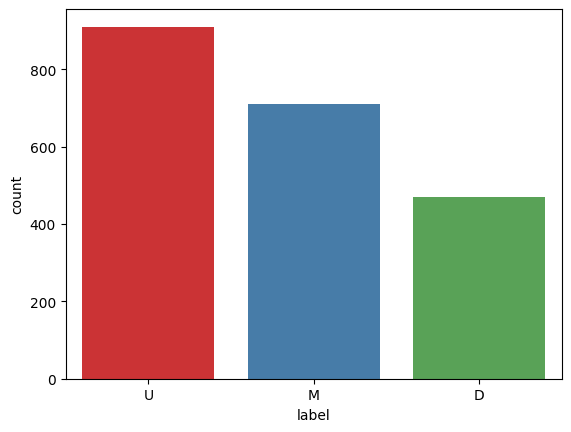

In [4]:
df = describe_dataset('train_side_clean.csv')
sns.countplot(x='label', data=df, palette="Set1") 
df.loc[df["label"] == "D", "label"] = 0
df.loc[df["label"] == "M", "label"] = 1
df.loc[df["label"] == "U", "label"] = 2

## Phân chia dữ liệu

### Chia dữ liệu

In [5]:
X = df.drop("label", axis=1)
y = df["label"].astype("int")

In [6]:
# Xác định các cột phân loại và cột số
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Tạo ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ])

### Thử nghiệm các mô hình

In [7]:
algorithms = [
    ("LR", LogisticRegression(random_state=seed)),
    (
        "SVC",
        SVC(
            probability=True,
            random_state=seed,
        ),
    ),
    ("KNN", KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier(random_state=seed)),
    ("SGDC", CalibratedClassifierCV(SGDClassifier(random_state=seed))),
    ("NB", GaussianNB()),
    (
        "RF",
        RandomForestClassifier(
            n_estimators=100,
            random_state=seed,
        ),
    ),
]

cv_results = {}
for name, model in algorithms:
    # Tạo pipeline bao gồm preprocessor và mô hình
    pipeline = Pipeline([("preprocessor", preprocessor), ("model", model)])
    
    # Thực hiện cross-validation
    cv_scores = cross_val_score(
        pipeline, X, y, cv=repeated_stratify_cv, scoring="accuracy"
    )
    cv_results[name] = cv_scores.mean()

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    print(f"{name}: {score}")

LR: 0.8763697121591858
SVC: 0.9040897698792437
KNN: 0.8860826308194729
DTC: 0.8656952988531935
SGDC: 0.8452904989747094
NB: 0.8279258752942963
RF: 0.9103015113541431


### Thử nghiệm lại preprocessor

In [8]:
transformed_X = preprocessor.fit_transform(X)
new_columns = numerical_cols.to_list()

transformed_X = pd.DataFrame(transformed_X, columns=new_columns)
X = transformed_X
X

,nose_x,nose_y,nose_z,left_shoulder_x,left_shoulder_y,left_shoulder_z,right_shoulder_x,right_shoulder_y,right_shoulder_z,left_hip_x,...,left_knee_z,right_knee_x,right_knee_y,right_knee_z,left_ankle_x,left_ankle_y,left_ankle_z,right_ankle_x,right_ankle_y,right_ankle_z
0,-0.480073,0.323811,0.753059,0.277659,0.318330,-0.784155,-0.341151,0.412576,1.447741,0.736188,...,-0.757102,-0.158252,0.097208,1.181802,0.396273,-0.014140,-1.186539,-0.281956,-0.317082,0.961118
1,-0.781627,0.377637,0.442913,-0.204809,0.370513,-0.953264,-0.534317,0.477594,1.283081,0.413400,...,-0.604724,-0.107148,0.145526,1.262025,-0.279191,-0.035862,-0.934780,-0.802545,-0.283179,1.154114
2,-0.758554,0.352314,0.683087,-0.082356,0.341392,-0.855642,-0.458462,0.478205,1.392330,0.347163,...,-0.671059,-0.053949,0.155816,1.172331,-0.159845,-0.021175,-1.067634,-0.480295,-0.284353,0.946885
3,-0.734242,0.354610,0.819993,-0.125179,0.341046,-0.738891,-0.494277,0.558792,1.391116,0.563122,...,-0.775932,-0.154266,0.116308,1.128543,-0.381844,-0.023535,-1.219091,-0.755335,-0.318923,0.886710
4,-0.671376,0.346165,0.656055,0.029893,0.360224,-0.825547,-0.394288,0.525970,1.362452,0.548806,...,-0.630255,-0.111569,0.090513,1.072483,-0.190560,-0.085704,-0.943487,-0.404022,-0.312420,0.859331
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2087,-1.009279,-0.271039,0.689132,-1.390160,-0.170022,-0.396983,-0.867508,-0.404156,0.867457,-0.840072,...,-0.578982,-0.976345,-1.589476,0.672604,-1.359693,-0.633942,-0.449781,-0.567108,-1.009154,0.332915
2088,0.969830,-0.421748,0.763173,0.777434,-0.351407,0.906794,1.330588,-0.363380,-0.413470,-0.982434,...,0.508531,1.498554,-0.827713,-0.701506,0.720310,-0.511182,0.107468,1.382008,-0.323274,-0.746572
2089,0.920793,-0.443889,0.695248,0.683233,-0.384891,0.780728,1.231591,-0.383263,-0.394864,-0.824315,...,0.539066,1.466982,-0.803211,-0.706566,0.144614,-0.956709,0.096613,0.758498,-0.696520,-0.715246
2090,0.867545,-0.203436,0.496393,0.652782,-0.060339,0.625355,1.077398,-0.040427,-0.455569,-0.786811,...,0.421748,1.365599,-1.216222,-0.589280,0.424910,-0.891456,0.021653,1.139560,-0.653114,-0.658252


In [9]:
def evaluate_model(name, model, results):
    # Đánh giá Model
    accuracy = cross_val_score(
        model, X, y, cv=repeated_stratify_cv, scoring="accuracy", n_jobs=-1
    ).mean()

    f1_score = cross_val_score(model, X, y, cv=k_fold, scoring="f1_macro").mean()
    results.append((name, accuracy, f1_score))

In [10]:
def print_results(results):
    results.sort(key=lambda el: el[2], reverse=True)

    return pd.DataFrame(
        results,
        columns=[
            "Model",
            "Accuracy score",
            "F1 score",
        ],
    )

# Chọn bộ tham số

#### Dùng GridSearchCV (Dùng để tìm bộ tham số nên không chạy run all)

In [ ]:
best_params_grid = {}
models_tuned_grid = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("LR", LogisticRegression()),
    ("SVC", SVC(probability=True)),
    ('KNN', KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier()),
    ("SGDC", CalibratedClassifierCV(SGDClassifier())),
    ("NB", GaussianNB()),
    ('RF', RandomForestClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "LR": {
        "C": np.logspace(-4, 4, 20),  # More granular range for C
        "solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # Added 'newton-cg'
        "penalty": ["l1", "l2", "elasticnet", "none"]  # Different norms for regularization
    },
    "DTC": {
        "max_depth": [None, 3, 5, 10, 15, 20, 30, 50, 100],  # Expanded range
        "min_samples_split": [2, 5, 10, 20, 40, 100],  # More options
        "min_samples_leaf": [1, 2, 5, 10, 20]  # Added min_samples_leaf
    },
    "RF": {
        "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],  # More options for n_estimators
        "max_features": ["auto", "sqrt", "log2", 0.2, 0.4, 0.6],  # More granular control
        "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],  # Added max_depth
        "min_samples_split": [2, 5, 10, 20],  # Added min_samples_split
        "min_samples_leaf": [1, 2, 4, 6]  # Added min_samples_leaf
    },
    "SVC": {
        "C": [0.1, 1, 10, 50, 100, 200, 300],  # Expanded C range
        "gamma": ["scale", "auto", 0.01, 0.1, 1, 10, 20],  # More granular gamma range
        "kernel": ["linear", "poly", "rbf", "sigmoid"]  # Added kernel options
    },
    "KNN": {
        "n_neighbors": list(range(1, 21)),  # More neighbors
        "weights": ["uniform", "distance"],  # Existing weights
        "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]  # Added distance metrics
    }
}

# Grid Search application with check for parameter grid existence
for name, model in models.items():
    print("Model processing: ", name)
    if name in param_grid:
        grid_search = GridSearchCV(
            estimator=model, 
            param_grid=param_grid[name], 
            cv=5, 
            scoring='accuracy', 
            n_jobs=-1,  # Sử dụng tất cả các lõi CPU để tăng tốc quá trình
            verbose=1  # Hiển thị tiến trình trong quá trình tìm kiếm
        )
        grid_search.fit(X_train, y_train)
        best_params_grid[name] = grid_search.best_params_
        models_tuned_grid[name] = grid_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


In [ ]:
with open('best_params1.json', 'w') as f:
    json.dump(best_params_grid, f)

In [ ]:
# Printing the best parameters for each model
print("Best parameters for each model:")
for name, params in best_params_grid.items():
    print(f"{name}: {params}")

# Printing the tuned models
print("\nTuned models:")
for name, model in models_tuned_grid.items():
    print(f"{name}: {model}")


#### Dùng RandomizedSearchCV (Dùng để tìm bộ tham số nên không chạy run all)

##### SVC

In [ ]:
best_params_SVC = {}
models_tuned_SVC = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("SVC", SVC(probability=True)),
]

# Define parameter grid with correct keys
param_grid = {
    "SVC": {
        "C": [0.001, 0.01, 0.1, 1, 10, 100],  # Expanded C range
        "gamma": [0.001, 0.01, 0.1, 1, 10, 100],  # More granular gamma range
        "kernel": ["linear", "poly", "rbf", "sigmoid"],  # Added kernel options
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_SVC[name] = randomized_search.best_params_
        models_tuned_SVC[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


In [ ]:
with open('best_params/best_params_SVC.json', 'w') as f:
    json.dump(best_params_SVC, f)

##### RF

In [ ]:
best_params_RF = {}
models_tuned_RF = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ('RF', RandomForestClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "RF": {
        "n_estimators": [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],  # More options for n_estimators
        "max_features": ["auto", "sqrt", "log2", 0.2, 0.4, 0.6],  # More granular control
        "max_depth": [int(x) for x in np.linspace(10, 110, num = 11)] + [None],  # Added max_depth
        "min_samples_split": [2, 5, 10, 20],  # Added min_samples_split
        "min_samples_leaf": [1, 2, 4, 6]  # Added min_samples_leaf
    }
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_RF[name] = randomized_search.best_params_
        models_tuned_RF[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


##### Các thuật toán khác

In [ ]:
best_params_random_other = {}
models_tuned_random_other = {}

# Adjust your algorithms list to use descriptive names that match param_grid
algorithms = [
    ("LR", LogisticRegression()),
    ('KNN', KNeighborsClassifier()),
    ("DTC", DecisionTreeClassifier()),
]

# Define parameter grid with correct keys
param_grid = {
    "LR": {
        "C": np.logspace(-4, 4, 20),  # More granular range for C
        "solver": ["liblinear", "lbfgs", "saga", "newton-cg"],  # Added 'newton-cg'
        "penalty": ["l1", "l2", "elasticnet", "none"]  # Different norms for regularization
    },
    "DTC": {
        "max_depth": [None, 3, 5, 10, 15, 20, 30, 50, 100],  # Expanded range
        "min_samples_split": [2, 5, 10, 20, 40, 100],  # More options
        "min_samples_leaf": [1, 2, 5, 10, 20]  # Added min_samples_leaf
    },
    "KNN": {
        "n_neighbors": list(range(1, 21)),  # More neighbors
        "weights": ["uniform", "distance"],  # Existing weights
        "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]  # Added distance metrics
    },
}


# Randomized Search application with check for parameter grid existence
for name, model in algorithms:
    print("Model processing: ", name)
    if name in param_grid:
        randomized_search = RandomizedSearchCV(
            estimator=model, 
            param_distributions=param_grid[name], 
            n_iter=100,  # You can adjust the number of iterations
            cv=5, 
            scoring='accuracy', 
            random_state=42,
            n_jobs=-1,
            verbose=1
        )
        randomized_search.fit(X, y)
        best_params_random_other[name] = randomized_search.best_params_
        models_tuned_random_other[name] = randomized_search.best_estimator_
    else:
        print(f"No parameter grid defined for {name}")


#### Thử nghiệm bộ tham số

In [11]:
with open('best_params_side.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=42)),
    ("SVC", SVC(probability=True, **best_params.get("SVC", {}), random_state=42)),
    ('KNN', KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=42)),
    ("SGDC", CalibratedClassifierCV(SGDClassifier(**best_params.get("SGDC", {})))),
    ("NB", GaussianNB()),  # GaussianNB không có tham số cụ thể để điều chỉnh
    ('RF', RandomForestClassifier(**best_params.get("RF", {}), random_state=42)),
]

models = {}
final_results = []

for name, model in algorithms:
    trained_model = model.fit(X, y)
    models[name] = trained_model
    evaluate_model(name, model, final_results)

print_results(final_results)

,Model,Accuracy score,F1 score
0,RF,0.913971,0.872714
1,LR,0.876048,0.835385
2,DTC,0.894214,0.834754
3,SVC,0.909189,0.822934
4,KNN,0.893254,0.795437
5,SGDC,0.849116,0.759235
6,NB,0.827926,0.751237


##### SVC

In [12]:
with open('best_params_side/best_params_SVC.json', 'r') as f:
    best_params = json.load(f)

# Khởi tạo và huấn luyện mô hình với tham số tốt nhất
svc_model = SVC(probability=True, **best_params.get("SVC", {}), random_state=42)
svc_model.fit(X, y)

# Lưu mô hình vào file
with open('best_models/SVC_model_side.pkl', 'wb') as file:
    pickle.dump(svc_model, file)

##### Random forest

In [13]:
with open('best_params_side/best_params_RF.json', 'r') as f:
    best_params_RF = json.load(f)

# Khởi tạo và huấn luyện mô hình với tham số tốt nhất
rf_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=42)
rf_model.fit(X, y)

# Lưu mô hình vào file
with open('best_models/RF_model_side.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

#### Các thuật toán khác: LR, KNN, DTC

In [ ]:
with open('best_params/best_params_random_other.json', 'r') as f:
    best_params = json.load(f)

# Assuming 'best_params' has been filled with the best parameters for each model from GridSearchCV or RandomizedSearchCV
algorithms = [
    ("LR", LogisticRegression(**best_params.get("LR", {}), random_state=42)),
    ('KNN', KNeighborsClassifier(**best_params.get("KNN", {}))),
    ("DTC", DecisionTreeClassifier(**best_params.get("DTC", {}), random_state=42)),
]

cv_results = {}
for name, model in algorithms:
    cv_scores = cross_val_score(model, X, y, cv=5)  # Thực hiện cross-validation với số lượng fold là 5
    cv_results[name] = cv_scores.mean()  # Lưu kết quả trung bình của các fold

# Hiển thị kết quả cross-validation
for name, score in cv_results.items():
    algorithms_score_df.append({
        "model": name,
        "score": score
    })
    print(f"{name}: {score}")

#### Confusion matrix:

##### Random forest

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict

In [16]:
with open('best_params_side/best_params_RF.json', 'r') as f:
    best_params = json.load(f)
    
rf_best_model = RandomForestClassifier(**best_params_RF.get("RF", {}), random_state=seed)
rf_best_model.fit(X, y)

RandomForestClassifier(max_depth=10, min_samples_leaf=6, min_samples_split=4,
                       n_estimators=400, random_state=42)

In [17]:
y_pred = rf_best_model.predict(X)
cm_full_train = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)
cm_full_train, accuracy

(array([[439,  30,   2],
        [ 23, 668,  20],
        [  0,  24, 886]], dtype=int64),
 0.9526768642447419)

In [18]:
accuracy = cross_val_score(rf_best_model, X, y, cv=k_fold, scoring="accuracy").mean()
y_pred = cross_val_predict(rf_best_model, X, y, cv=k_fold)
cm_cross_val = confusion_matrix(y, y_pred)
accuracy, cm_cross_val

(0.8823741171109593,
 array([[401,  68,   2],
        [ 70, 600,  41],
        [  0,  65, 845]], dtype=int64))

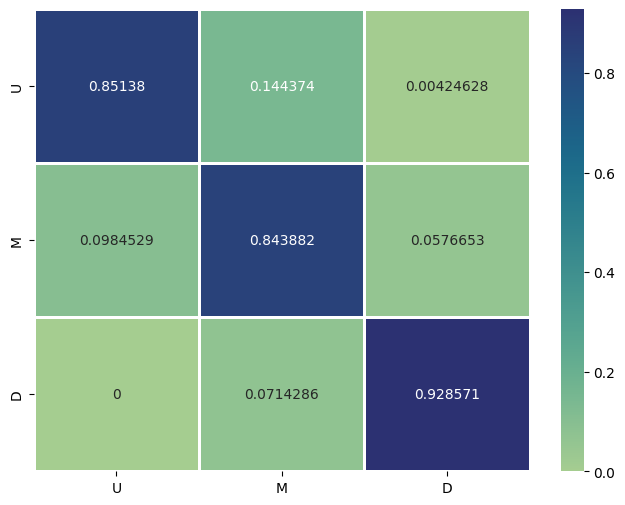

In [19]:
label_counts = np.sum(cm_cross_val, axis=1)
cm_cross_val = cm_cross_val / label_counts[:, None]
confusion_matrix_df = pd.DataFrame(cm_cross_val, index=["U", "M", "D"], columns=["U", "M", "D"])

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, linewidths=1, annot=True, ax=ax, fmt="g", cmap="crest");